### EnKF Inviscid Burgers

In [7]:
using Revise
using LinearAlgebra
using InvariantDA
using TransportBasedInference
using Statistics
using Distributions
using PDMats
using FFTW
using OrdinaryDiffEq
using ProgressMeter
using JLD
using SparseArrays

Load some packages to make nice figures

In [8]:
using CairoMakie
using LaTeXStrings
using ColorSchemes
using NamedColors

### Simple twin-experiment

Define the dimension of the state and observation vectors

In [9]:
Nx = 200
Ny = 20

20

Define the time steps $\Delta t_{dyn}, \Delta t_{obs}$  of the dynamical and observation models. Observations from the truth are assimilated every $\Delta t_{obs}$.

In [10]:
Δtdyn = 0.001
Δtobs = 0.1

0.1

Define the time span of interest

In [11]:
t0 = 0.0
Tf = 2000
Tspin = 1000
tf = t0 + Tf*Δtobs

200.0

 Define the distribution for the initial condition $\pi_{\mathsf{X}_0}$

In [12]:
π0 = MvNormal(zeros(Nx), Matrix(1.0*I, Nx, Nx))

FullNormal(
dim: 200
μ: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
Σ: [1.0 0.0 … 0.0 0.0; 0.0 1.0 … 0.0 0.0; … ; 0.0 0.0 … 1.0 0.0; 0.0 0.0 … 0.0 1.0]
)


We construct the state-space representation `F` of the system composed of the deterministic part of the dynamical and observation models. 

The dynamical model is provided by the right hand side of the system of ODEs to solve. For a system of ODEs, we will prefer the in-place syntax `f(du, u, p, t)`, where `p` are parameters of the model used in `OrdinaryDiffEq`. With this package, we integrate the dynamical system with the Tsitouras 5/4 Runge-Kutta method with an adaptive time marching. 

We assume that the state is fully observable, i.e. $h(x, t) = x$.

Note: the right-hand-side of the Lorenz-63 model is implemented in `TransportBasedInference` under the name `lorenz63!`. The code is reproduced for convenience.

```
function lorenz63!(du,u,p,t)
    du[1] = 10.0*(u[2]-u[1])
    du[2] = u[1]*(28.0-u[3]) - u[2]
    du[3] = u[1]*u[2] - (8/3)*u[3]
    return du
end
```

In [13]:
# Parameters to set-up the linear advection problem
L = 1.0
Δx = L/Nx
xgrid = Δx*(0.5 .+ collect(1:Nx))
    
# params = Dict("nx" => nx,
#               "f" => zeros(nx),
#               "fP" => zeros(nx),
#               "fN" => zeros(nx), 
#               "ps" => zeros(nx),
#               "fL" => zeros(nx+1), 
#               "fR" => zeros(nx+1))
# params = (Nx, 
#           Δx,
#           zeros(Nx),
#           zeros(Nx),
#           zeros(Nx), 
#           zeros(Nx), 
#           zeros(Nx+1),
#           zeros(Nx+1))

params = Burgers_Rusanov(Nx, 
                         Δx,
                         zeros(Nx+1),
                         zeros(Nx+1),
                         zeros(Nx+1),
                         zeros(Nx+1),
                         zeros(Nx+1),
                         zeros(Nx+1))

Burgers_Rusanov(200, 0.005, [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0])

In [14]:
cfl = Δtdyn/Δx

0.2

In [15]:
# u0(x) = sin(2*π*x) + 0.5*sin(π*x) + 0.2*sin(π/2*x)

# u0d = 1.0 .+ irfft((randn(Nx÷2+1) + im*randn(Nx÷2+1)).* map(k-> exp(-0.5*k^3.0), 1:Nx÷2+1), Nx)/Δx;

# # u0d = rand(π0)

In [16]:
πmass = Normal(1.0, 0.1)
αk = 1.0

1.0

In [17]:
m0 = rand(πmass)

1.208757791701996

In [18]:
ϕm = ones(Nx)/sqrt(Nx)

Qm = qr(ϕm).Q;
Qperp = Qm*Matrix(1.0*I, Nx, Nx)[:,2:end];

In [19]:
function initial_condition(m, ϕm::Vector{Float64}, αk, Δx, Nx::Int64)
    
    @assert isapprox(norm(ϕm), 1.0, atol = 1000*eps())
        
    xparallel = irfft((randn(Nx÷2+1) + im*randn(Nx÷2+1)).* map(k-> exp(-0.5*k^αk), 1:Nx÷2+1), Nx)/Δx
    
    return ϕm*m + xparallel - ϕm*dot(ϕm, xparallel)
end

initial_condition (generic function with 1 method)

In [20]:
x0 = initial_condition(m0, ϕm, αk, Δx, Nx);

In [21]:
x0'*ϕm-m0

-2.220446049250313e-16

In [22]:
# save("initial_condition_linear_advection.jld", "x0", x0)

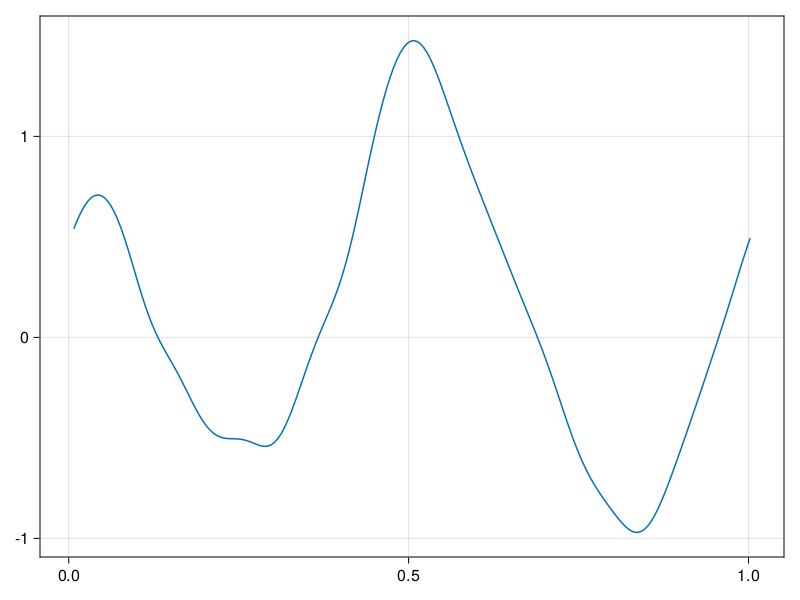

In [23]:
lines(xgrid, x0)

In [24]:
# plot(xgrid, u0.(xgrid))

In [25]:
h(x, t) = x[1:10:end]
H = sparse(Matrix(1.0*I, Nx, Nx)[1:10:end,:])
# F = StateSpace((du, u, p, t) -> burgers_weno!(du, u, params, t), h)
F = StateSpace((du, u, p, t) -> burgers_rusanov!(du, u, params, t), h)

StateSpace(var"#5#6"(), TransportBasedInference.var"#24#25"(), h)

`ϵx` defines the additive process noise applied between the forecast step and the analysis step. The process noise is applied before to sample from the likelihood model.

`ϵy` defines the additive observation noise. 

We assume that the noise distributions are Gaussian.

In [26]:
σx = 1e-16
σy = 0.01

ϵx = AdditiveInflation(Nx, zeros(Nx), σx)
ϵy = AdditiveInflation(Ny, zeros(Ny), σy)

AdditiveInflation(20, [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0001 0.0 … 0.0 0.0; 0.0 0.0001 … 0.0 0.0; … ; 0.0 0.0 … 0.0001 0.0; 0.0 0.0 … 0.0 0.0001], [0.01 0.0 … 0.0 0.0; 0.0 0.01 … 0.0 0.0; … ; 0.0 0.0 … 0.01 0.0; 0.0 0.0 … 0.0 0.01])

Different types of inflation have been implemented in `TransportBasedInference`:
        
* `IdentityInflation` applies the identity transformation
* `AdditiveInflation` applies Gaussian noise to the ensemble members
* `MultiplicativeInflation` increases the spread of the ensemble  about the sample mea by a multiplicative factor $\beta$.
* `MultiAddInflation` combine a multiplicative and an additive inflation.

They are all subtypes of the abstract type `InflationType`.

New types of inflation can easily be created and integrated in the existing tools of `TransportBasedInference`, as long as the satisfy the following requirements: 

* `MyInflationType <: InflationType` 
* `(A::MyInflationType)(X::AbstractMatrix{Float64})` is defined

In [27]:
model = Model(Nx, Ny, Δtdyn, Δtobs, ϵx, ϵy, π0, 0, 0, 0, F);

Run dynamics and generate data

For the twin-experiment, we use the function `generate_lorenz63` to integrate forward in time the Lorenz-63 ODE, and generate the observations that will be later assimilated in the ensemble filter. This function can easily be modified for your specific needs.

In [28]:
data = generate_data_inviscid_burgers(model, x0, Tf);

Progress: 100%|█████████████████████████████████████████| Time: 0:00:08


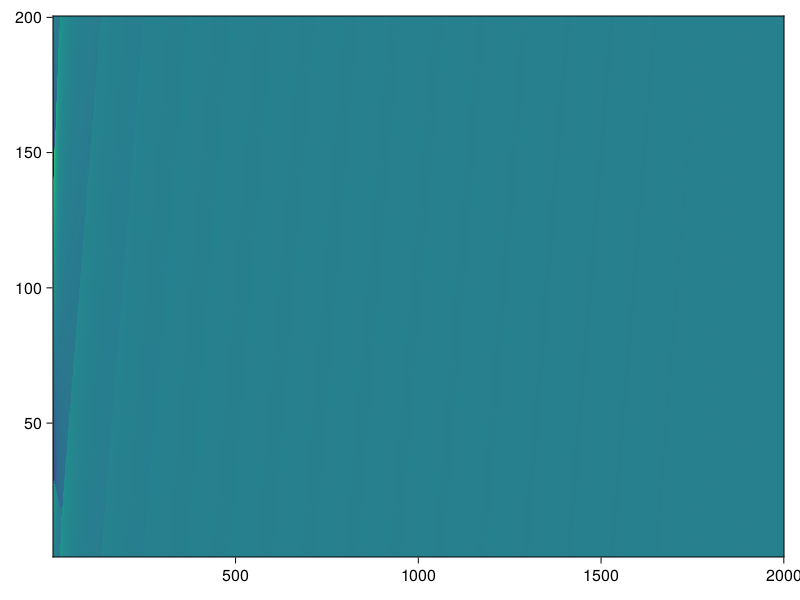

In [29]:
heatmap(data.xt[:, 1:end]')

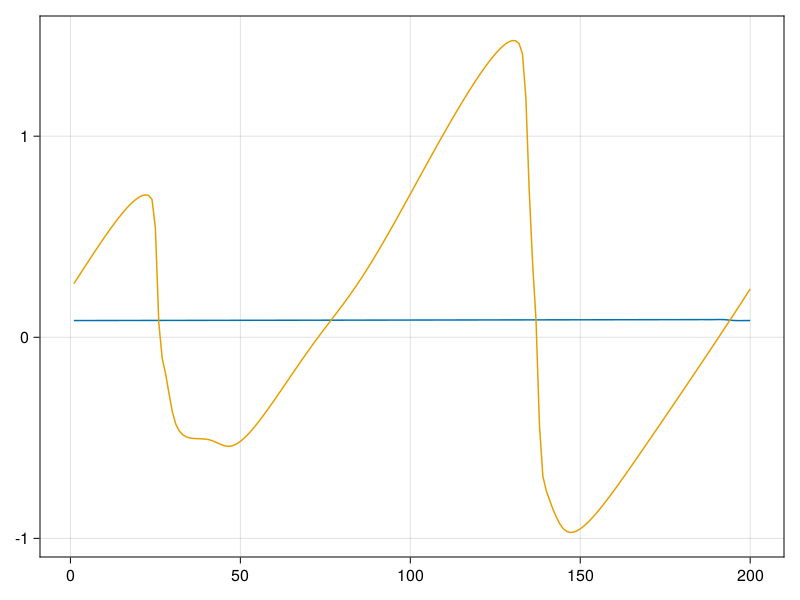

In [30]:
fig = Figure()
ax = Axis(fig[1,1])

lines!(ax, data.xt[:,2000])
lines!(ax, data.xt[:,1])

fig

In [31]:
lines(data.x0)
lines!(data.xt[:,1000])

Lines{Tuple{Vector{Point{2, Float32}}}}

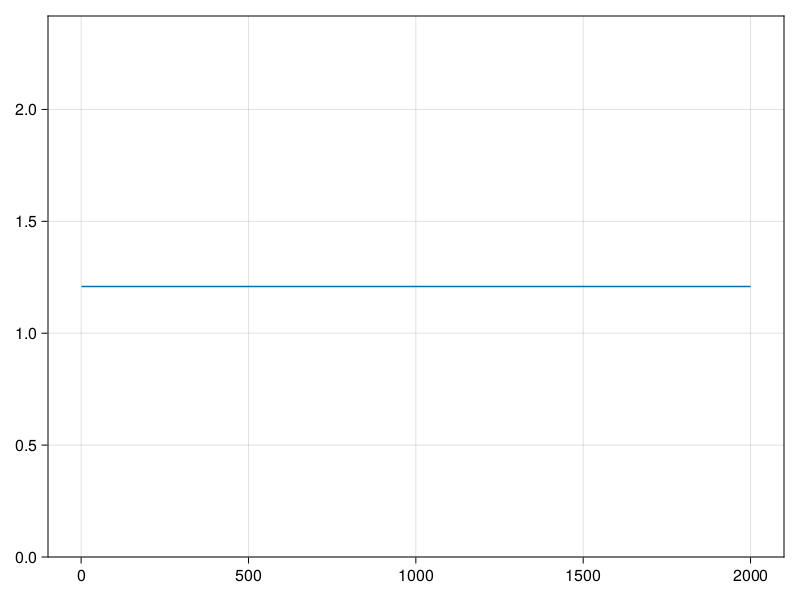

In [32]:
fig = Figure()
ax = Axis(fig[1,1])
lines!(ax, data.xt'*ϕm)

# ylims!(ax, [8, 9])
fig

In `TransportBasedInference`, we use the following convention to store the state and observation variables. The state and observation variables of the different ensemble members are stored in a common matrix `X`. The different columns store the different samples. The first entries of a column contains the observation variables, while the latter contains the state variables. This convention might seem confusing at first, but it is very convenient for conditional density estimation, see notebook 2 or 5 for instance.

Different ensemble filters have been implemented in `TransportBasedInference`:
        
* `IdFilter`: a trivial identity filter

* `StochEnKF`: the stochastic version of the ensemble Kalman filter (sEnKF), Evensen [1].

* `ETKF`: the ensemble transform Kalman filter (ETKF) Bishop et al. [3]. This filter exactly verifies the propagation equation for the covariance matrix of the Kalman filter, and avoid to sample the observation noise. This filter belongs to the class of deterministic ensemble Kalman filters.

* `StochMapFilter`: the stochastic map filter (SMF) developed by Spantini et al. [5]. This filter is a nonlinear generalization of the stochastic EnKF based on measure transport. This filter is presented in the notebooks 6 & 7.

New ensemble filter can easily be created and integrated in the existing tools of `TransportBasedInference`, as long as they satisfy the following requirements: 

* `MyFilterType <: SeqFilter` 
* `(A::MyFilterType)(X::AbstractMatrix{Float64}, ystar, t)` is defined, where `ystar` is the observation to assimilate in the forecast ensemble `X`.

Define a stochastic ensemble Kalman filter

In [33]:
enkf = LikEnKF(model.ϵy, model.Δtdyn, model.Δtobs)

Likelihood-based EnKF  with filtered = false


In [34]:
Δ = 10
yidx = 1:Δ:Nx
@assert size(yidx,1) == Ny
idx = vcat(collect(1:length(yidx))', collect(yidx)')

# Create Localization structure
Gxx(i,j) = periodicmetric!(i,j, Nx)
Gxy(i,j) = periodicmetric!(i,yidx[j], Nx)
Gyy(i,j) = periodicmetric!(yidx[i],yidx[j], Nx)

Gyy (generic function with 1 method)

In [35]:
Lrad = 15

15

In [36]:
Loc = Localization(Lrad, Gxx, Gxy, Gyy)
enkf = LocEnKF(model.ϵy, model.Δtdyn, model.Δtobs, Loc, H)

# enkf = LikEnKF(model.ϵy, model.Δtdyn, model.Δtobs)#, Loc, H)

Localized EnKF with filtered = false


In [37]:
β = 1.01

1.01

In [38]:
# ϵxβ = MultiAddInflation(Nx, β, zeros(Nx), 1e-2)
ϵβ = MultiplicativeInflation(β)

MultiplicativeInflation(1.01)

Define an instance of the ensemble robust filter

Initialize the ensemble matrix `X` $\in \mathbb{R}^{(N_y + N_x) \times N_e}$.

In [39]:
# SMOOTH RANDOM FUNCTIONS, RANDOM ODEs, AND GAUSSIAN PROCESSES Trefethen

In [40]:
Ne = 30
#ensemble size
X = zeros(model.Ny + model.Nx, Ne)

# Different options for the initial condition

# Option 1: Random initial conditions
# viewstate(X, model.Ny, model.Nx) .= rand(model.π0, Ne)

# # Option 2: Ensure that all the samples have exactly the right mass
# for i=1:Ne
#     xperpi = randn(Nx-1)
#     X[Ny+1:Ny+Nx,i] = ϕm*m0 + Qperp*xperpi
# end

# Option 3: The samples have a mass within some reasonable bound
for i=1:Ne
#     xsmoothi = irfft((randn(Nx÷2+1) + im*randn(Nx÷2+1)).* map(k-> exp(-0.5*k^(3.0)), 1:Nx÷2+1), Nx)/Δx;
#     mi = m0*rand(πm0)# (1+ 0.10*(2*rand()-1.0))
    
#     X[Ny+1:Ny+Nx,i] = ϕm*mi + (I- ϕm*ϕm')*(xsmoothi)
    
    mi = rand(πmass)
    X[Ny+1:Ny+Nx,i] = initial_condition(mi, ϕm, αk, Δx, Nx)
end

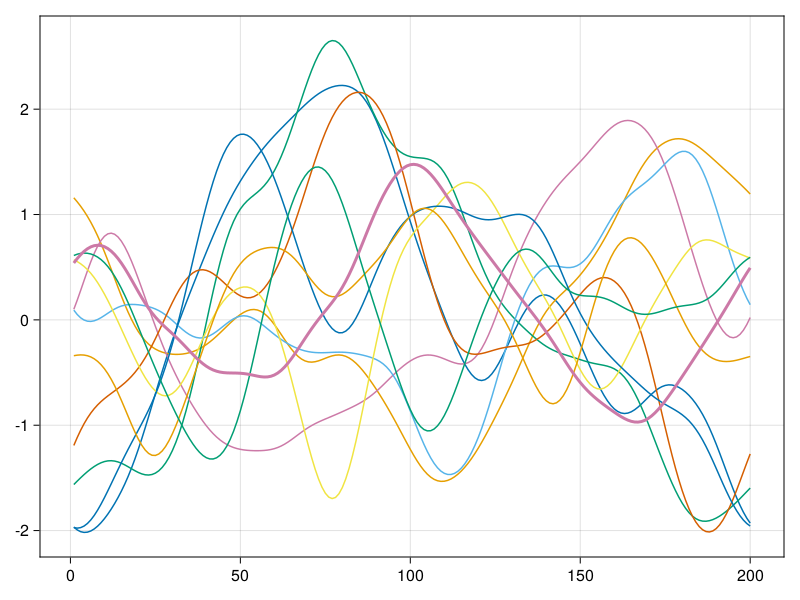

In [41]:
fig = Figure()

ax = Axis(fig[1,1])

for i=1:10
    lines!(ax, X[Ny+1:Ny+Nx,i])
end

lines!(ax, x0, linewidth = 3)

fig

In [42]:
ϕm'*X[Ny+1:Ny+Nx,:]

1×30 adjoint(::Vector{Float64}) with eltype Float64:
 1.05614  1.00405  1.04501  0.933464  …  0.971729  1.14438  0.757134  1.0486

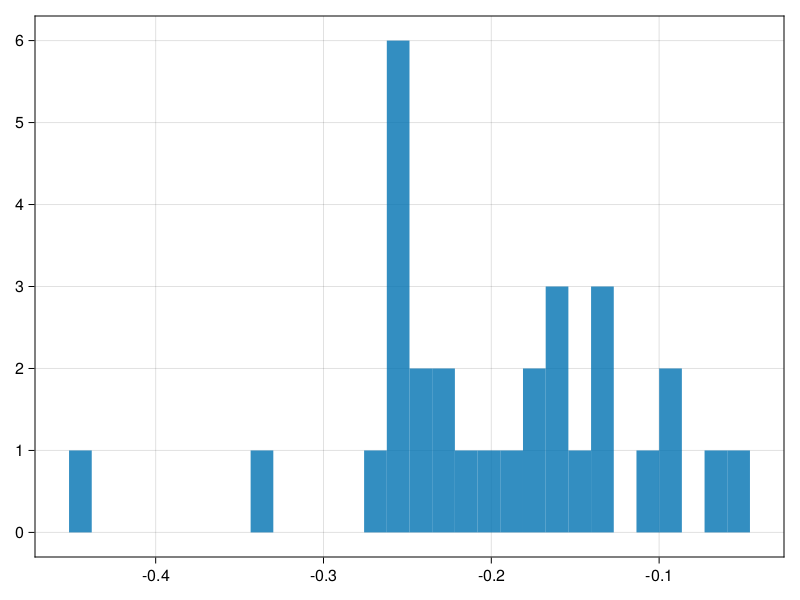

In [43]:
hist((ϕm'*X[Ny+1:Ny+Nx,:])[1,:] .- m0; bins = 30)

Apply the sequential filter over the time window

In [44]:
# locX = Locgaspari((Nx, Nx), enkf.Loc.L, enkf.Loc.Gxx)
# heatmap(locX')

The function `seqassim` provides a friendly API to experiment with the different ensemble filters, the tuning of the different inflation parameters...

In [45]:
@time Xenkf = seqassim_inviscid_burgers(F, data, Tf, ϵβ, enkf, deepcopy(X), model.Ny, model.Nx, t0);

205.906029 seconds (265.30 M allocations: 22.197 GiB, 1.15% gc time, 1.70% compilation time)


In [46]:
rmse_enkf = mean(map(i->norm(data.xt[:,i]-mean(Xenkf[i+1]; dims = 2))/sqrt(Nx), Tspin:Tf))

0.0020031019518368985

In [ ]:
@time Xenkf_mass = seqassim_project_mass_inviscid_burgers(F, data, Tf, ϵβ, ϕm, enkf, deepcopy(X), model.Ny, model.Nx, t0);

In [ ]:
rmse_enkf_mass = mean(map(i->norm(data.xt[:,i]-mean(Xenkf_mass[i+1]; dims = 2))/sqrt(Nx), Tspin:Tf))

In [ ]:
fig = Figure()
ax = Axis(fig[1,1])
lines!(ax, map(i->norm(data.xt[:,i]-mean(Xenkf[i+1]; dims = 2))/sqrt(Nx), 1:Tf), yscale = :log10)
lines!(ax, map(i->norm(data.xt[:,i]-mean(Xenkf_mass[i+1]; dims = 2))/sqrt(Nx), 1:Tf), yscale = :log10)

fig

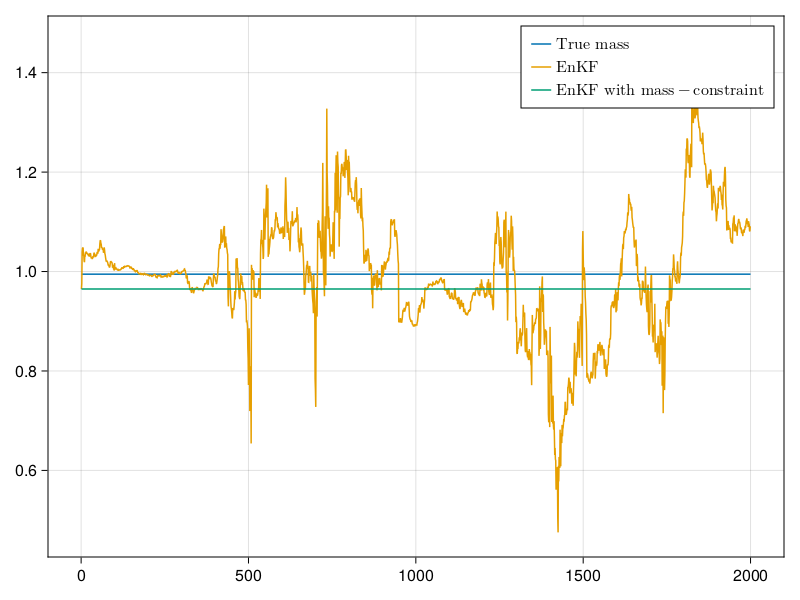

In [230]:
fig = Figure()

ax = Axis(fig[1,1])

lines!(ax, (ϕm'*data.xt)[1,:], label = L"\text{True mass}")
lines!(ax, map(i-> ϕm'*mean(Xenkf[i]; dims = 2)[:,1], 1:Tf), label  = L"\text{EnKF}")
lines!(ax, map(i-> ϕm'*mean(Xenkf_mass[i]; dims = 2)[:,1], 1:Tf), label  = L"\text{EnKF with mass\text{-}constraint}")

axislegend()

fig

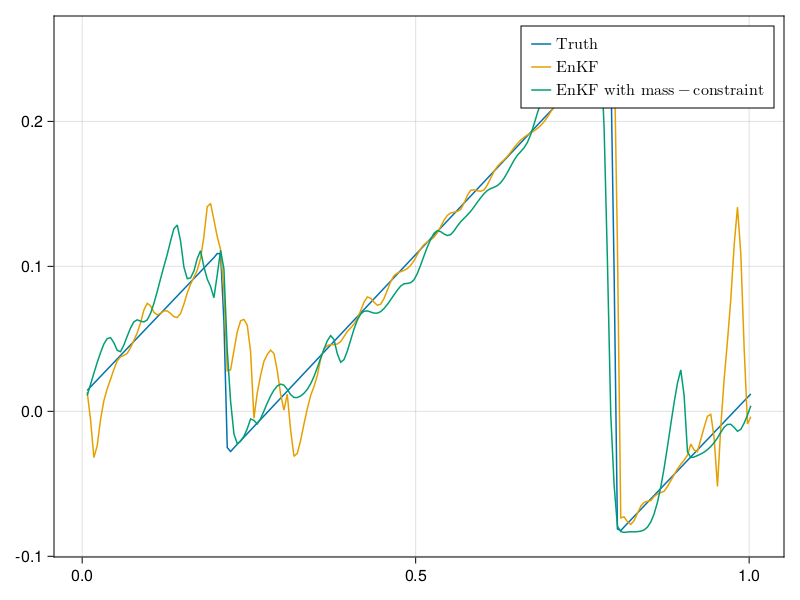

In [234]:
fig = Figure()

ax = Axis(fig[1,1])

tsnap = 2000
lines!(ax, xgrid, data.xt[:,tsnap], label = L"\text{Truth}")
# scatter!(ax, xgrid[1:Δ:end], data.yt[:,tsnap])

# scatt
# lines!(ax, Xenkf[tsnap+1][:,10])
# lines!(ax, Xenkf[tsnap+1][:,50])
# lines!(ax, Xenkf[tsnap+1][:,100])

lines!(ax, xgrid, mean(Xenkf[tsnap+1]; dims = 2)[:,1], label  = L"\text{EnKF}")
lines!(ax, xgrid, mean(Xenkf_mass[tsnap+1]; dims = 2)[:,1], label  = L"\text{EnKF with mass\text{-}constraint}")

# scatter!(ax, xgrid, Xenkf_mass[tsnap+1][:,1])

axislegend()

fig

In [152]:
mean(map(tsnap -> norm(mean(Xenkf_mass[tsnap+1]; dims = 2)[:,1] - data.xt[:,tsnap])/norm(data.xt[:,tsnap]), 1001:2000))

0.5856283879529723

In [151]:
# rmse_enkf_lasso = mean(map(i->norm(data.xt[:,i]-mean(Xenkflasso[i+1]; dims = 2))/sqrt(Nx), 1:100))
# plot(map(i->norm(data.xt[:,i]-mean(Xenkflasso[i+1]; dims = 2))/sqrt(Nx), 1:Tf), yscale = :log10)
# rmse_enkf_lasso_mass = mean(map(i->norm(data.xt[:,i]-mean(Xenkflasso_mass[i+1]; dims = 2))/sqrt(Nx), 1:Tf))
# (rmse_enkf_lasso-rmse_enkf_lasso_mass)/rmse_enkf_lasso
# plot(map(i->norm(data.xt[:,i]-mean(Xenkflasso_mass[i+1]; dims = 2))/sqrt(Nx), 1:Tf), yscale = :log10)

In [152]:
# @time Xenkflasso = seqassim_inviscid_burgers(F, data, Tf, ϵβ, enkf_lasso, deepcopy(X), model.Ny, model.Nx, t0);

In [153]:
# @time Xenkflasso_mass = seqassim_inviscid_burgers_mass(F, data, Tf, ϵβ, ϕm, enkf_lasso, deepcopy(X), model.Ny, model.Nx, t0);